In [36]:
import pandas as pd 
import numpy as np  
import seaborn as sns 
import matplotlib.pyplot as  plt 
import cv2
import os
import tensorflow as tf 
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization,Conv2D,MaxPooling2D,Flatten,InputLayer,Input
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler,ModelCheckpoint
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.applications import ResNet152V2,DenseNet121,InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Accuracy,TruePositives,TrueNegatives,FalseNegatives,FalsePositives
from tensorflow.keras.regularizers import L2
from sklearn.metrics import confusion_matrix,classification_report,roc_curve,roc_auc_score
import warnings
warnings.filterwarnings("ignore")
import glob
import yaml
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import ResNet50

In [38]:
Train = "C:/Users/Owen/Downloads/chest_xray/chest_xray/train"
Val = "C:/Users/Owen/Downloads/chest_xray/chest_xray/val"
Test = "C:/Users/Owen/Downloads/chest_xray/chest_xray/test"

# Data Cleaning

In [41]:
Pneumonia_train = "C:/Users/Owen/Downloads/chest_xray/chest_xray/train/PNEUMONIA"
Normal_train = "C:/Users/Owen/Downloads/chest_xray/chest_xray/train/NORMAL"

Jumlah_Pneumonia = len([f for f in os.listdir(Pneumonia_train) if os.path.isfile(os.path.join(Pneumonia_train, f))])
Jumlah_Normal = len([f for f in os.listdir(Normal_train) if os.path.isfile(os.path.join(Normal_train,f))])

print(f"Number of files Pneumonia Train : {Jumlah_Pneumonia}")
print(f"Number of files Normal in Train : {Jumlah_Normal}")

Number of files Pneumonia Train : 3502
Number of files Normal in Train : 1218


In [43]:
Pneumonia_val = "C:/Users/Owen/Downloads/chest_xray/chest_xray/val/PNEUMONIA"
Normal_val = "C:/Users/Owen/Downloads/chest_xray/chest_xray/val/NORMAL"

Jumlah_Pneumonia = len([f for f in os.listdir(Pneumonia_val) if os.path.isfile(os.path.join(Pneumonia_val, f))])
Jumlah_Normal = len([f for f in os.listdir(Normal_val) if os.path.isfile(os.path.join(Normal_val,f))])

print(f"Number of files Pneumonia Validation : {Jumlah_Pneumonia}")
print(f"Number of files Normal in Validation : {Jumlah_Normal}")

Number of files Pneumonia Validation : 381
Number of files Normal in Validation : 131


In [51]:
train_ds = tf.keras.utils.image_dataset_from_directory("C:/Users/Owen/Downloads/chest_xray/chest_xray/train")
for images, labels in train_ds.take(1):
    print(images.dtype)  # float32 (numerik)
    print(labels.dtype)  # float32 (numerik)

Found 5216 files belonging to 2 classes.
<dtype: 'float32'>
<dtype: 'int32'>


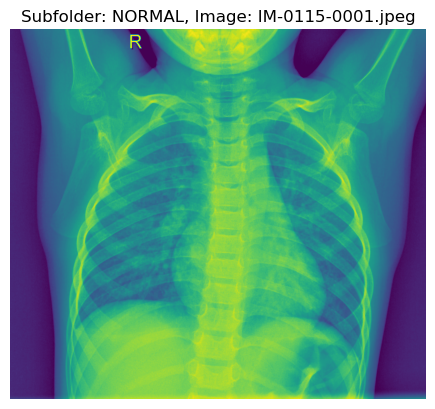

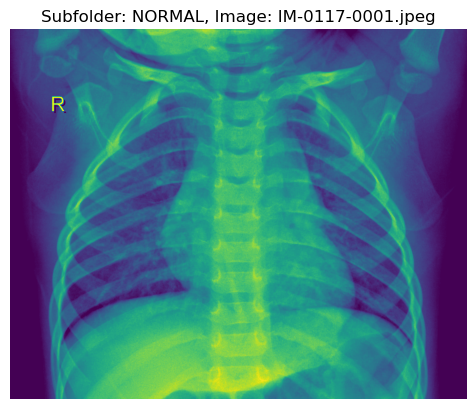

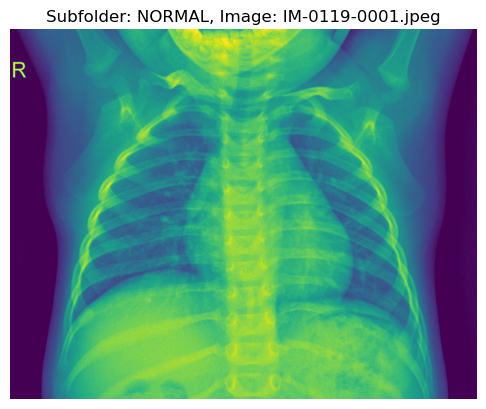

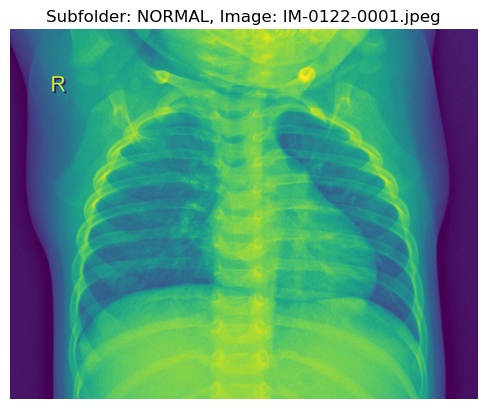

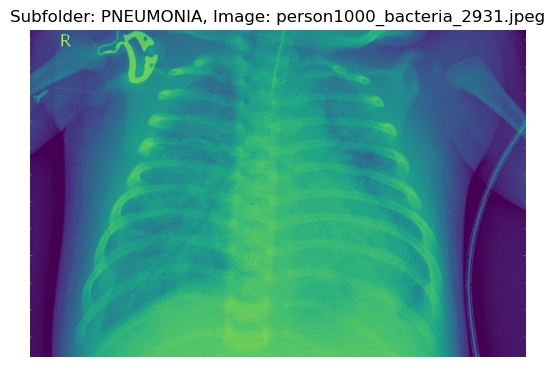

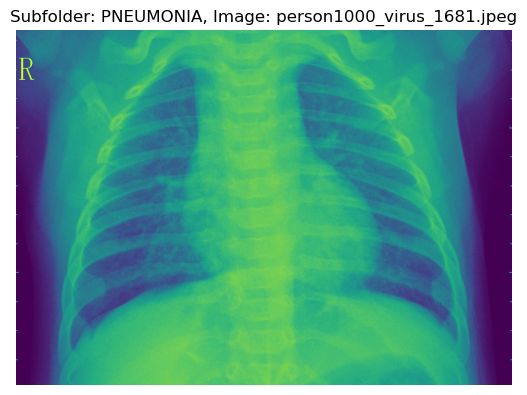

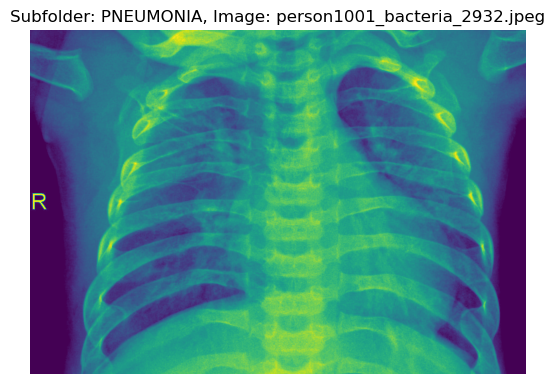

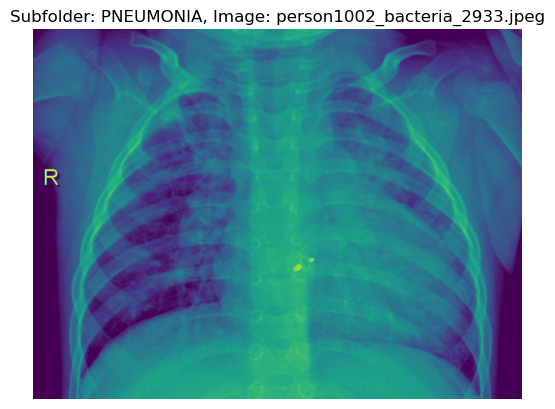

In [7]:
import matplotlib.image as mpimg

for subfolder in os.listdir(Train):
    subfolder_path = os.path.join(Train, subfolder)
    if os.path.isdir(subfolder_path):
        for image_file in os.listdir(subfolder_path)[:4]:
            image_path = os.path.join(subfolder_path, image_file)
            image = mpimg.imread(image_path)
            plt.imshow(image)
            plt.title(f'Subfolder: {subfolder}, Image: {image_file}')
            plt.axis('off')
            plt.show()    

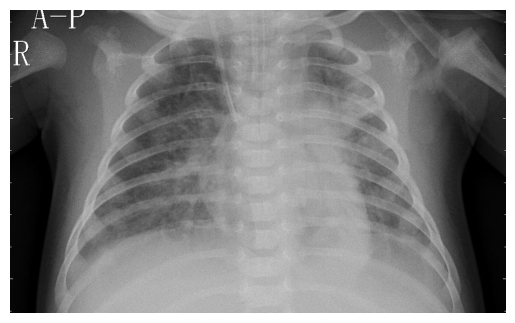

In [8]:
Pneumonia_img = glob.glob("C:/Users/Owen/Downloads/chest_xray/chest_xray/val/PNEUMONIA/*")
Normal_img = glob.glob("C:/Users/Owen/Downloads/chest_xray/chest_xray/val/Normal/*")
img1 = cv2.imread(Pneumonia_img[0])
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
plt.imshow(img1)
plt.axis('off')
plt.show()

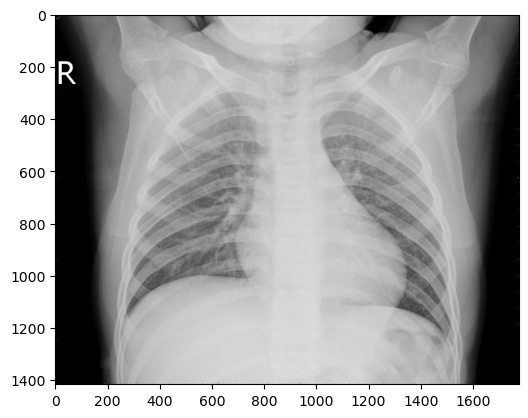

In [14]:
img2 = cv2.imread(Normal_img[0])
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(img2)
plt.show()

In [17]:
print(f"Foto satu size ya : {img1.shape}")
print(f"Foto kedua size ya : {img2.shape}")

Foto satu size ya : (592, 968, 3)
Foto kedua size ya : (1416, 1776, 3)


In [215]:
Normal_valid = glob.glob("C:/Users/Owen/Downloads/chest_xray/chest_xray/val/NORMAL/*")
for image in Normal_valid :
    img = cv2.imread(image)
    if img is not None :
        height,width,_ = img.shape
        print(f"Gambar: {image}, Resolusi: {width}x{height}")

Gambar: C:/Users/Owen/Downloads/chest_xray/chest_xray/val/NORMAL\IM-0115-0001.jpeg, Resolusi: 2090x1858
Gambar: C:/Users/Owen/Downloads/chest_xray/chest_xray/val/NORMAL\IM-0117-0001.jpeg, Resolusi: 1422x1152
Gambar: C:/Users/Owen/Downloads/chest_xray/chest_xray/val/NORMAL\IM-0119-0001.jpeg, Resolusi: 1810x1434
Gambar: C:/Users/Owen/Downloads/chest_xray/chest_xray/val/NORMAL\IM-0122-0001.jpeg, Resolusi: 1618x1279
Gambar: C:/Users/Owen/Downloads/chest_xray/chest_xray/val/NORMAL\IM-0125-0001.jpeg, Resolusi: 1600x1125
Gambar: C:/Users/Owen/Downloads/chest_xray/chest_xray/val/NORMAL\IM-0127-0001.jpeg, Resolusi: 1974x1306
Gambar: C:/Users/Owen/Downloads/chest_xray/chest_xray/val/NORMAL\IM-0128-0001.jpeg, Resolusi: 1528x1013
Gambar: C:/Users/Owen/Downloads/chest_xray/chest_xray/val/NORMAL\IM-0129-0001.jpeg, Resolusi: 1384x1167
Gambar: C:/Users/Owen/Downloads/chest_xray/chest_xray/val/NORMAL\IM-0131-0001.jpeg, Resolusi: 1450x1144
Gambar: C:/Users/Owen/Downloads/chest_xray/chest_xray/val/NORMAL

In [216]:
blur_train = glob.glob("C:/Users/Owen/Downloads/chest_xray/chest_xray/train/NORMAL/*")

def blur_or_not(image_path, threshold=100):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        laplacian = cv2.Laplacian(img,cv2.CV_64F).var()
        return laplacian
    return None

for img_path in blur_train :
    blur_score = blur_or_not(img_path)
    if blur_score < 100 :
        print(f"⚠️ Gambar {img_path} mungkin buram!")

⚠️ Gambar C:/Users/Owen/Downloads/chest_xray/chest_xray/train/NORMAL\IM-0301-0001.jpeg mungkin buram!
⚠️ Gambar C:/Users/Owen/Downloads/chest_xray/chest_xray/train/NORMAL\IM-0333-0001.jpeg mungkin buram!
⚠️ Gambar C:/Users/Owen/Downloads/chest_xray/chest_xray/train/NORMAL\IM-0401-0001.jpeg mungkin buram!
⚠️ Gambar C:/Users/Owen/Downloads/chest_xray/chest_xray/train/NORMAL\IM-0403-0001.jpeg mungkin buram!
⚠️ Gambar C:/Users/Owen/Downloads/chest_xray/chest_xray/train/NORMAL\IM-0413-0001.jpeg mungkin buram!
⚠️ Gambar C:/Users/Owen/Downloads/chest_xray/chest_xray/train/NORMAL\IM-0425-0001.jpeg mungkin buram!
⚠️ Gambar C:/Users/Owen/Downloads/chest_xray/chest_xray/train/NORMAL\IM-0429-0001-0001.jpeg mungkin buram!
⚠️ Gambar C:/Users/Owen/Downloads/chest_xray/chest_xray/train/NORMAL\IM-0429-0001.jpeg mungkin buram!
⚠️ Gambar C:/Users/Owen/Downloads/chest_xray/chest_xray/train/NORMAL\IM-0433-0001.jpeg mungkin buram!
⚠️ Gambar C:/Users/Owen/Downloads/chest_xray/chest_xray/train/NORMAL\IM-0434-

In [217]:
blur = [img_path for img_path in blur_train if blur_or_not(img_path) is not None and blur_or_not(img_path) < 100]

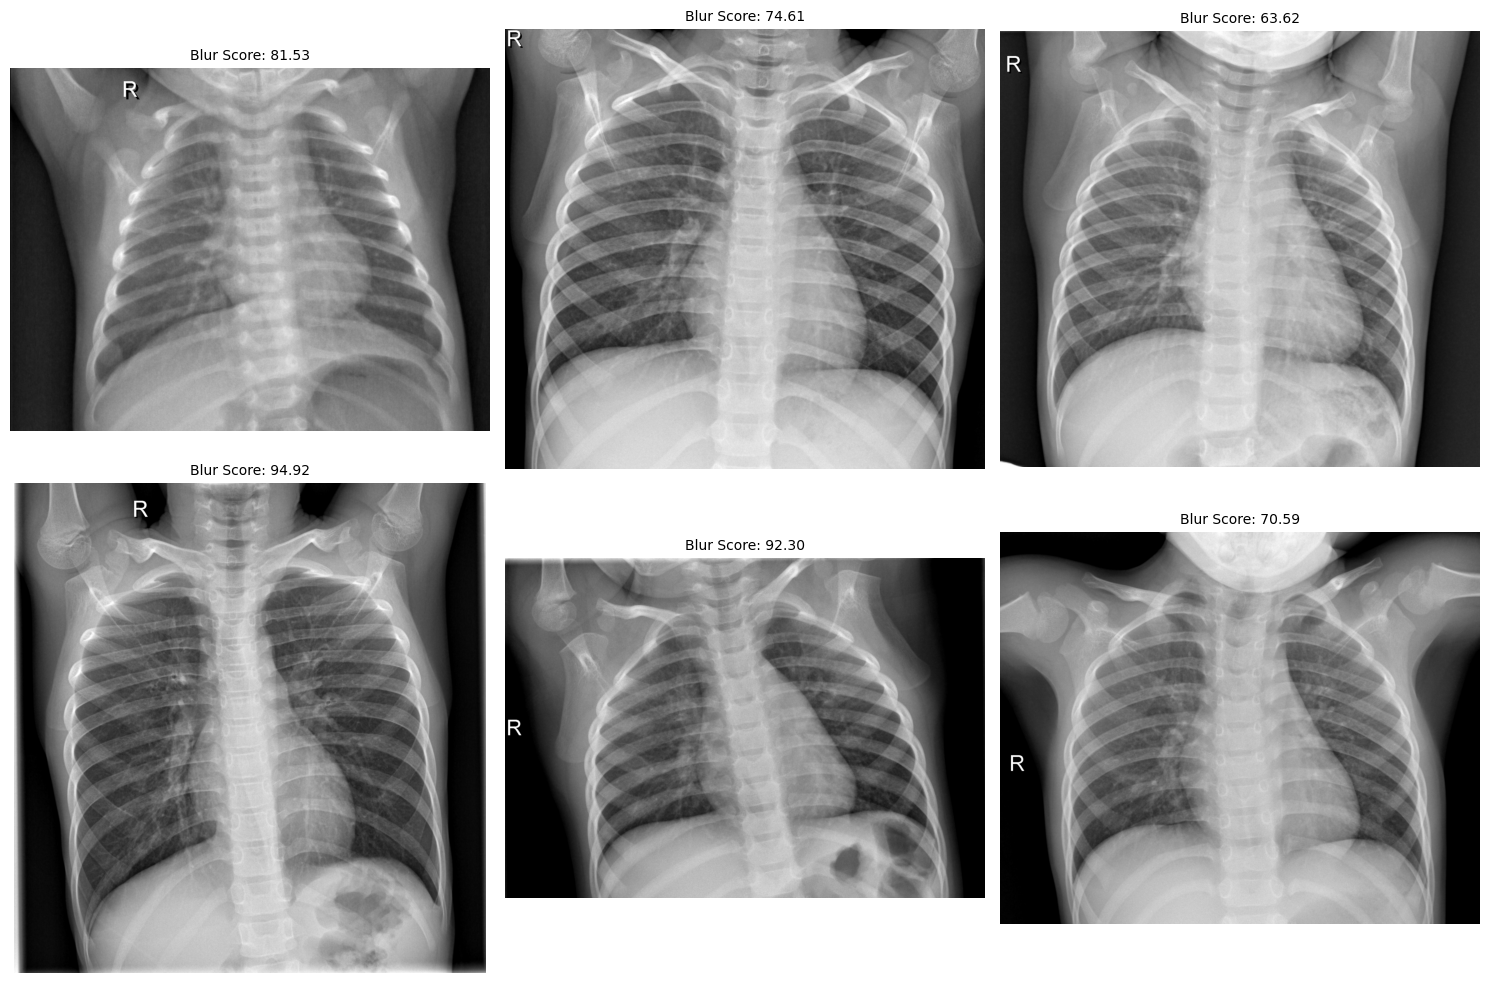

In [219]:
plt.figure(figsize=(15,10))

for i, image_path in enumerate(blur[1:7]):
    # Baca gambar
    img1 = cv2.imread(image_path)
    
    # Konversi BGR ke RGB
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    
    # Buat subplot
    plt.subplot(2, 3, i+1)
    plt.imshow(img1)
    plt.axis('off')
    
    # Tambahkan skor blur di judul
    blur_score = blur_or_not(image_path)
    plt.title(f'Blur Score: {blur_score:.2f}', fontsize=10)

plt.tight_layout()
plt.show()

In [45]:
class_names = ['NORMAL','PNEUMONIA']
Train_dataset = tf.keras.utils.image_dataset_from_directory(
    Train,
    labels='inferred',
    label_mode='int',
    class_names=class_names,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    seed=42
)

Found 4720 files belonging to 2 classes.


In [46]:
class_names = ['NORMAL','PNEUMONIA']
Validation_dataset = tf.keras.utils.image_dataset_from_directory(
    Val,
    labels = 'inferred',
    label_mode = 'int',
    class_names = class_names,
    color_mode = 'rgb',
    batch_size=32,
    image_size = (224,224),
    seed=42
)

Found 512 files belonging to 2 classes.


In [47]:
class_names = ['NORMAL','PNEUMONIA']
Test_dataset = tf.keras.utils.image_dataset_from_directory(
    Test,
    labels = 'inferred',
    label_mode = 'int',
    class_names = class_names,
    color_mode = 'rgb',
    batch_size=32,
    image_size = (224,224),
    seed=42
)

Found 624 files belonging to 2 classes.


# MobileNetV2

In [51]:
checkpoint_path = "/kaggle/working/best_model.keras"  # Change the extension to .h5
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,  # Corrected parameter name and file extension
    monitor='val_loss',  # Metric to monitor
    save_best_only=True,  # Save only the best model
    mode='min',  # 'min' for loss, 'max' for accuracy
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5, 
    verbose=1,
    mode='auto',
    restore_best_weights=True
)

In [102]:
Mobile.trainable = True  # Aktifkan semua lapisan MobileNetV2 untuk fine-tuning

# Opsional: Unfreeze hanya beberapa lapisan terakhir (lebih aman)
for layer in Mobile.layers[:-10]:  # Unfreeze 10 lapisan terakhir (sesuaikan jumlahnya)
    layer.trainable = False

# Kompilasi ulang model dengan learning rate lebih kecil
mobile_model.compile(
    loss=BinaryCrossentropy(),
    optimizer=Adam(learning_rate=0.000001),  # Learning rate lebih kecil untuk fine-tuning
    metrics=['accuracy']
)

# Langkah 4: Latih ulang model dengan fine-tuning
history_fine = mobile_model.fit(
    Train_dataset,
    validation_data=Validation_dataset,
    epochs=10,  # Kurangi epoch untuk fine-tuning, pantau loss
    callbacks=[checkpoint_callback, early_stopping]
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 991ms/step - accuracy: 0.9213 - loss: 0.2371   
Epoch 1: val_loss did not improve from 0.61879
163/163 ━━━━━━━━━━━━━━━━━━━━ 175s 1s/step - accuracy: 0.9213 - loss: 0.2372 - val_accuracy: 0.7500 - val_loss: 0.6461
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 991ms/step - accuracy: 0.9215 - loss: 0.2424  
Epoch 2: val_loss did not improve from 0.61879
163/163 ━━━━━━━━━━━━━━━━━━━━ 162s 994ms/step - accuracy: 0.9215 - loss: 0.2424 - val_accuracy: 0.7500 - val_loss: 0.6477
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9276 - loss: 0.2316      
Epoch 3: val_loss did not improve from 0.61879
163/163 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.9276 - loss: 0.2317 - val_accuracy: 0.7500 - val_loss: 0.6419
Epoch 4/10
156/163 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9273 - loss: 0.2323  

KeyboardInterrupt: 

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, GlobalAveragePooling2D

Mobile = MobileNetV2(input_shape=(224,224,3), include_top=False, weights='imagenet')
Mobile.trainable = False

model = Sequential()
model.add(Mobile)                       # Tambah MobileNetV2
model.add(GlobalAveragePooling2D())     # Pooling
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [38]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),    # Optimizer Adam dengan learning rate kecil
    loss=BinaryCrossentropy(),               # Loss untuk binary classification
    metrics=['accuracy']                     # Metrik untuk evaluasi
)

In [40]:
history = model.fit(
    Train_dataset,                          # Dataset pelatihan
    validation_data=Validation_dataset,     # Dataset validasi
    epochs=25,                              # Maksimum 25 epoch
    callbacks=[checkpoint_callback, early_stopping],  # Gunakan callbacks
    verbose=1                               # Tampilkan progress
)

Epoch 1/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7446 - loss: 0.6073     
Epoch 1: val_loss improved from inf to 0.54754, saving model to /kaggle/working/best_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.7448 - loss: 0.6068 - val_accuracy: 0.7500 - val_loss: 0.5475
Epoch 2/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 891ms/step - accuracy: 0.8560 - loss: 0.3795  
Epoch 2: val_loss did not improve from 0.54754
163/163 ━━━━━━━━━━━━━━━━━━━━ 146s 894ms/step - accuracy: 0.8561 - loss: 0.3794 - val_accuracy: 0.7500 - val_loss: 0.6358
Epoch 3/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 965ms/step - accuracy: 0.8855 - loss: 0.3191   
Epoch 3: val_loss did not improve from 0.54754
163/163 ━━━━━━━━━━━━━━━━━━━━ 158s 968ms/step - accuracy: 0.8856 - loss: 0.3190 - val_accuracy: 0.7500 - val_loss: 0.6252
Epoch 4/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 973ms/step - accuracy: 0.9115 - loss: 0.2672  
Epoch 4: val_loss did not improve from 0.54754
163/163 ━━━━━━━━━━━━━━━━━━━━ 159s 976ms/s

In [61]:
Mobile = MobileNetV2(input_shape=(224,224,3), include_top=False, weights='imagenet')
Mobile.trainable = False

inputs = Input(shape=(224,224,3))
X = Mobile(inputs)
X = GlobalAveragePooling2D()(X)
X = Dense(128, activation='relu')(X)
X = BatchNormalization()(X)
X = Dropout(0.3)(X)
X = Dense(64, activation='relu')(X)
X = BatchNormalization()(X)
X = Dropout(0.3)(X)
outputs = Dense(1, activation='sigmoid')(X)

model = Model(inputs, outputs)
model.compile(
    loss=BinaryCrossentropy(),
    optimizer=Adam(learning_rate=0.0001),  # Learning rate lebih kecil untuk fine-tuning
    metrics=['accuracy']
)

# Langkah 4: Latih ulang model dengan fine-tuning
history = model.fit(
    Train_dataset,
    validation_data=Validation_dataset,
    epochs=20,  # Kurangi epoch untuk fine-tuning, pantau loss
    callbacks=[checkpoint_callback, early_stopping]
)

Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6763 - loss: 0.6402     
Epoch 1: val_loss improved from 0.54754 to 0.51220, saving model to /kaggle/working/best_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.6768 - loss: 0.6395 - val_accuracy: 0.6875 - val_loss: 0.5122
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 974ms/step - accuracy: 0.8415 - loss: 0.3920  
Epoch 2: val_loss did not improve from 0.51220
163/163 ━━━━━━━━━━━━━━━━━━━━ 159s 977ms/step - accuracy: 0.8415 - loss: 0.3919 - val_accuracy: 0.7500 - val_loss: 0.6028
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8798 - loss: 0.3239      
Epoch 3: val_loss did not improve from 0.51220
163/163 ━━━━━━━━━━━━━━━━━━━━ 178s 1s/step - accuracy: 0.8798 - loss: 0.3238 - val_accuracy: 0.7500 - val_loss: 0.5541
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9005 - loss: 0.2787  
Epoch 4: val_loss did not improve from 0.51220
163/163 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step -

KeyboardInterrupt: 

In [32]:
Efficient = EfficientNetB0(input_shape=(224,224,3), include_top=False, weights='imagenet')
Efficient.trainable = False

a = Input(shape=(224,224,3))
b = Efficient(a)
b = GlobalAveragePooling2D()(b)
b = Dense(128, activation='relu')(b)
b = BatchNormalization()(b)
b = Dense(64, activation='relu')(b)
b = BatchNormalization()(b)
b = Dropout(0.3)(b)
outputs = Dense(1, activation='sigmoid')(b)

de_pu_model = Model(a, outputs)
de_pu_model.compile(
    loss=BinaryCrossentropy(),
    optimizer=Adam(learning_rate=0.0001), 
    metrics=['accuracy']
)

history = de_pu_model.fit(
    Train_dataset,
    validation_data=Validation_dataset,
    epochs=20,  
    callbacks=[checkpoint_callback, early_stopping]
)

Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7014 - loss: 0.6252  
Epoch 1: val_loss did not improve from 0.08450
163/163 ━━━━━━━━━━━━━━━━━━━━ 222s 1s/step - accuracy: 0.7019 - loss: 0.6244 - val_accuracy: 0.9375 - val_loss: 0.3934
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8883 - loss: 0.3166  
Epoch 2: val_loss did not improve from 0.08450
163/163 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.8883 - loss: 0.3166 - val_accuracy: 1.0000 - val_loss: 0.2068
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9282 - loss: 0.2324  
Epoch 3: val_loss did not improve from 0.08450
163/163 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.9282 - loss: 0.2324 - val_accuracy: 0.9375 - val_loss: 0.1702
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9342 - loss: 0.1984  
Epoch 4: val_loss did not improve from 0.08450
163/163 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.9342 - loss: 0.1984 - val_accuracy: 1.0000 - val_loss:

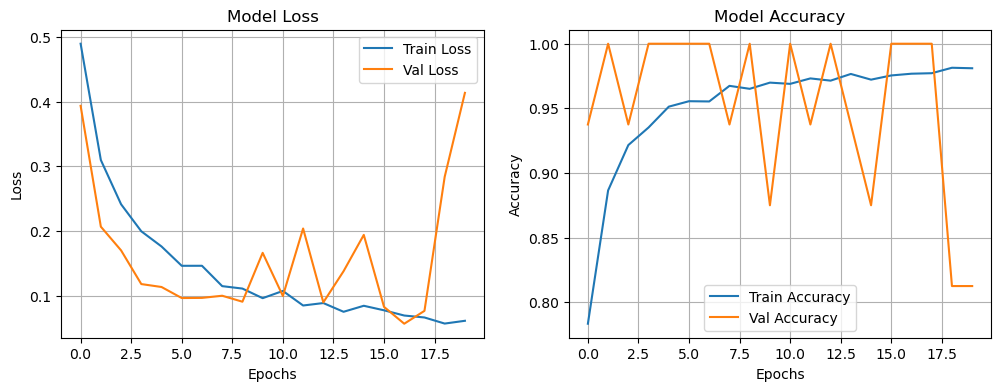

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


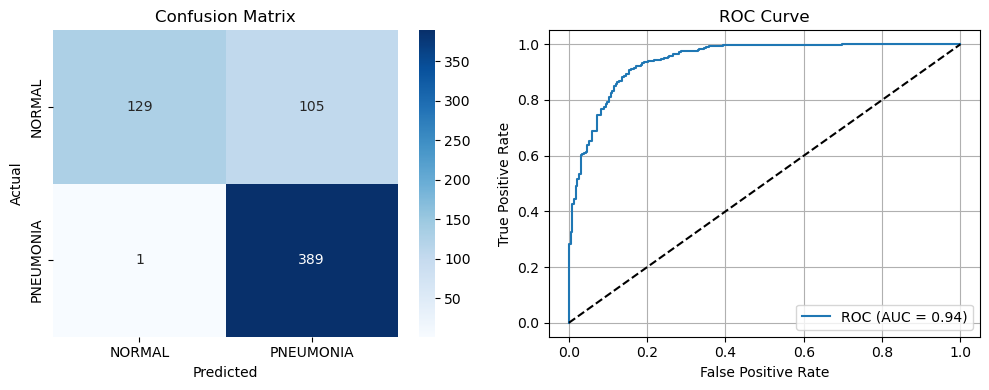

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

# Fungsi 1: Plot Loss dan Accuracy
def plot_training_history(model):
    history = model.history.history
    plt.figure(figsize=(12, 4))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title("Model Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Val Accuracy')
    plt.title("Model Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()
    
    plt.show()

# Fungsi 2: Evaluasi dan Plot Confusion Matrix + ROC
def evaluate_and_plot(model, dataset):
    all_true = []
    all_pred = []
    
    # Proses dataset batched
    for x, y in dataset:
        pred = model.predict(x)[:, 0]  # Prediksi per batch
        true = y.numpy()              # Label per batch
        all_true.extend(true)
        all_pred.extend(pred)
    
    true_label = np.array(all_true)
    predicted_prob = np.array(all_pred)
    predicted_label = (predicted_prob > 0.5).astype(int)
    
    # Plot Confusion Matrix
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(true_label, predicted_label)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', 
                xticklabels=['NORMAL', 'PNEUMONIA'], 
                yticklabels=['NORMAL', 'PNEUMONIA'])
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    
    # Plot ROC Curve
    plt.subplot(1, 2, 2)
    fp, tp, _ = roc_curve(true_label, predicted_prob)
    auc = roc_auc_score(true_label, predicted_prob)
    plt.plot(fp, tp, label=f'ROC (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid()
    
    plt.tight_layout()
    plt.show()
    
    return true_label, predicted_label

# Panggil fungsi
plot_training_history(de_pu_model)
true_label, pred_label = evaluate_and_plot(de_pu_model, Test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


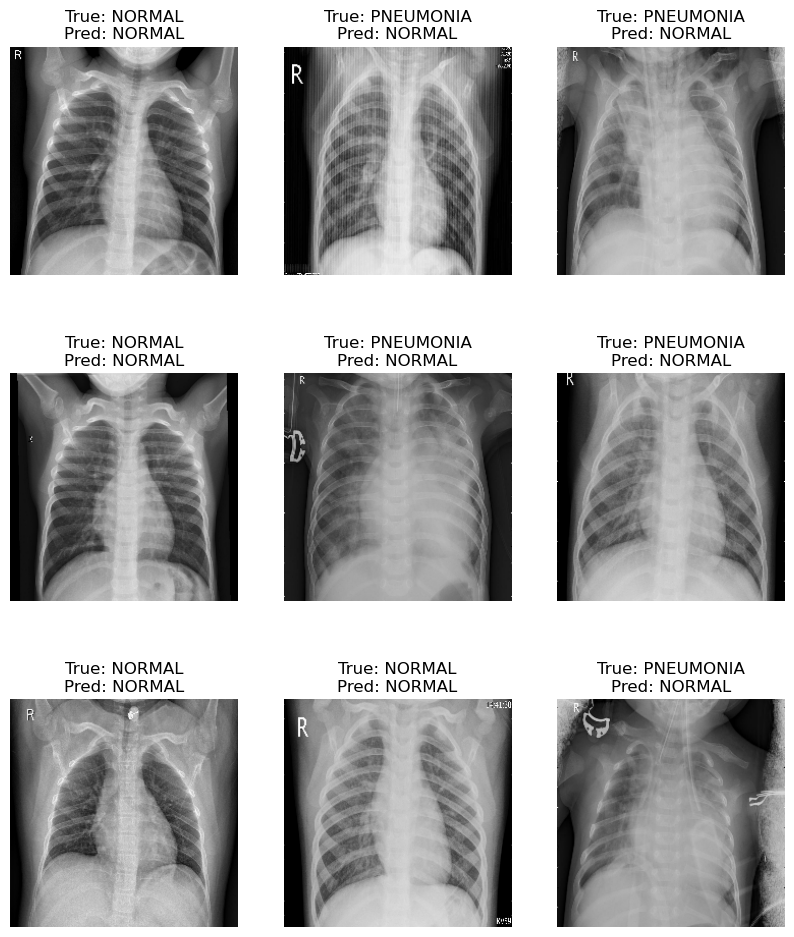

In [54]:
import matplotlib.pyplot as plt
import tensorflow as tf

def Pneumonia_or_not(x):
    return 'NORMAL' if x < 0.5 else 'PNEUMONIA'

plt.figure(figsize=(10, 12))
for i, (image, label) in enumerate(Test_dataset.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    img_int = tf.cast(image[0], tf.uint8)  # Untuk visualisasi
    plt.imshow(img_int)
    # Normalisasi untuk prediksi
    pred = de_pu_model.predict(tf.expand_dims(image[0] / 255.0, axis=0))[0][0]
    plt.title('True: ' + class_names[label[0]] + "\n" + 
              'Pred: ' + Pneumonia_or_not(pred))
    plt.axis('off')
plt.show()

In [69]:
Efficient = EfficientNetB0(input_shape=(224,224,3), include_top=False, weights='imagenet')
Efficient.trainable = False

a = Input(shape=(224,224,3))
b = Efficient(a)
b = GlobalAveragePooling2D()(b)
b = Dense(128, activation='relu')(b)
b = BatchNormalization()(b)
b = Dense(64, activation='relu')(b)
b = BatchNormalization()(b)
b = Dropout(0.3)(b)
outputs = Dense(1, activation='sigmoid')(b)

de_pu_model = Model(a, outputs)
de_pu_model.compile(
    loss=BinaryCrossentropy(),
    optimizer=Adam(learning_rate=0.0001), 
    metrics=['accuracy']
)

history = de_pu_model.fit(
    Train_dataset,
    validation_data=Validation_dataset,
    epochs=20,  
    callbacks=[checkpoint_callback, early_stopping]
)

Epoch 1/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7149 - loss: 0.6001  
Epoch 1: val_loss did not improve from 0.07723
148/148 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - accuracy: 0.7154 - loss: 0.5993 - val_accuracy: 0.9082 - val_loss: 0.3984
Epoch 2/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8825 - loss: 0.3195  
Epoch 2: val_loss did not improve from 0.07723
148/148 ━━━━━━━━━━━━━━━━━━━━ 245s 2s/step - accuracy: 0.8825 - loss: 0.3194 - val_accuracy: 0.9277 - val_loss: 0.2702
Epoch 3/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9128 - loss: 0.2505  
Epoch 3: val_loss did not improve from 0.07723
148/148 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.9128 - loss: 0.2505 - val_accuracy: 0.9609 - val_loss: 0.1723
Epoch 4/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9202 - loss: 0.2326  
Epoch 4: val_loss did not improve from 0.07723
148/148 ━━━━━━━━━━━━━━━━━━━━ 226s 2s/step - accuracy: 0.9203 - loss: 0.2325 - val_accuracy: 0.9629 - val_loss:

In [75]:
de_pu_model.evaluate(Test_dataset)

20/20 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.8195 - loss: 0.4939 


[0.4995317757129669, 0.8189102411270142]

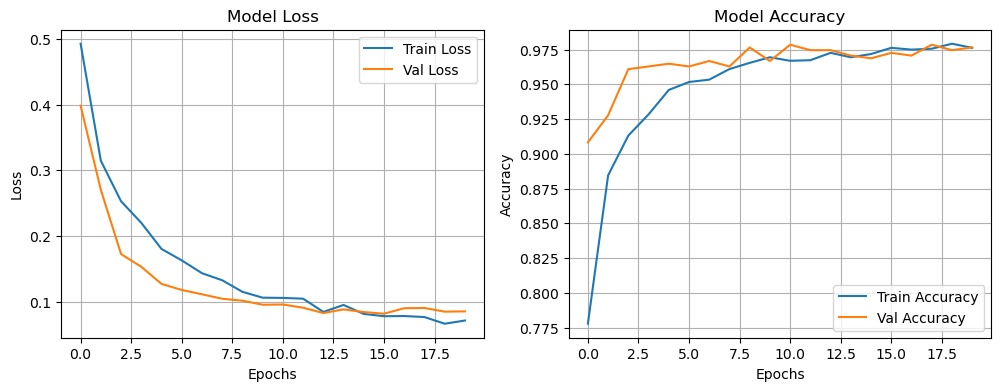

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


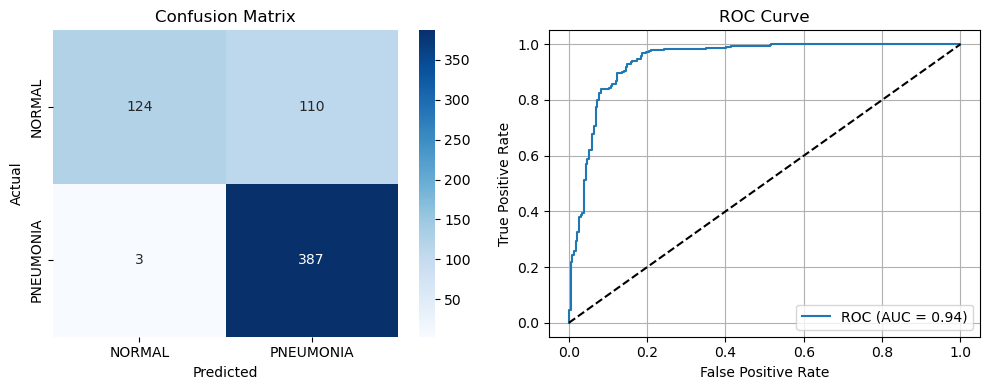

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

# Fungsi 1: Plot Loss dan Accuracy
def plot_training_history(model):
    history = model.history.history
    plt.figure(figsize=(12, 4))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title("Model Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Val Accuracy')
    plt.title("Model Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()
    
    plt.show()

# Fungsi 2: Evaluasi dan Plot Confusion Matrix + ROC
def evaluate_and_plot(model, dataset):
    all_true = []
    all_pred = []
    
    # Proses dataset batched
    for x, y in dataset:
        pred = model.predict(x)[:, 0]  # Prediksi per batch
        true = y.numpy()              # Label per batch
        all_true.extend(true)
        all_pred.extend(pred)
    
    true_label = np.array(all_true)
    predicted_prob = np.array(all_pred)
    predicted_label = (predicted_prob > 0.5).astype(int)
    
    # Plot Confusion Matrix
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(true_label, predicted_label)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', 
                xticklabels=['NORMAL', 'PNEUMONIA'], 
                yticklabels=['NORMAL', 'PNEUMONIA'])
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    
    # Plot ROC Curve
    plt.subplot(1, 2, 2)
    fp, tp, _ = roc_curve(true_label, predicted_prob)
    auc = roc_auc_score(true_label, predicted_prob)
    plt.plot(fp, tp, label=f'ROC (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid()
    
    plt.tight_layout()
    plt.show()
    
    return true_label, predicted_label

# Panggil fungsi
plot_training_history(de_pu_model)
true_label, pred_label = evaluate_and_plot(de_pu_model, Test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 909ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


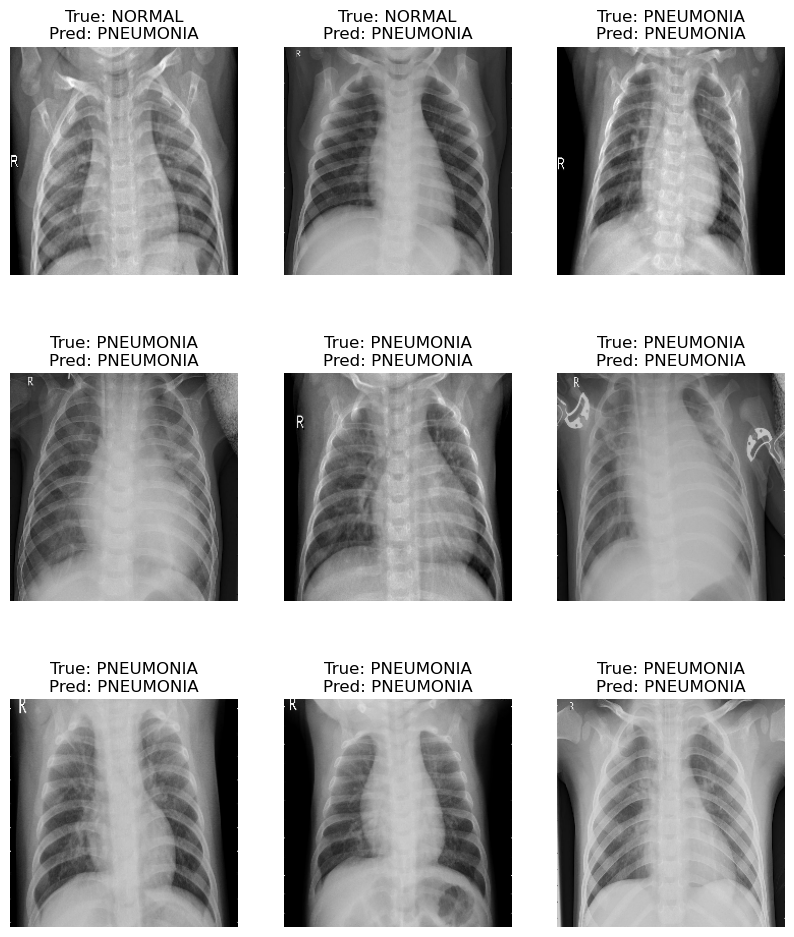

In [223]:
import matplotlib.pyplot as plt
import tensorflow as tf

def Pneumonia_or_not(x):
    return 'NORMAL' if x < 0.5 else 'PNEUMONIA'

plt.figure(figsize=(10, 12))
for i, (image, label) in enumerate(Test_dataset.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    img_int = tf.cast(image[0], tf.uint8)  
    plt.imshow(img_int)
    pred = de_pu_model.predict(tf.expand_dims(image[0] / 255.0, axis=0))[0][0]
    plt.title('True: ' + class_names[label[0]] + "\n" + 
              'Pred: ' + Pneumonia_or_not(pred))
    plt.axis('off')
plt.show()

In [103]:
de_pu_model.save('model.keras')

Masukkan path gambar:  C:\Users\Owen\Downloads\chest_xray\chest_xray\train\NORMAL\NORMAL2-IM-1141-0001.jpeg


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Raw Predictions: [[0.09138164]]
Gambar: C:\Users\Owen\Downloads\chest_xray\chest_xray\train\NORMAL\NORMAL2-IM-1141-0001.jpeg
Prediksi: NORMAL (Kepercayaan: 0.909)


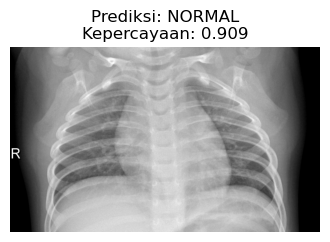

In [211]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array

# Load model
try:
    de_pu_model = tf.keras.models.load_model('C:/Users/Owen/model.keras')
except Exception as e:
    print(f"Error loading model: {e}")
    raise

# Definisikan ukuran dan kelas
img_size = (224, 224)
class_names = ['NORMAL', 'PNEUMONIA']  # Pastikan urutan sesuai pelatihan (0: NORMAL, 1: PNEUMONIA)

# Fungsi preprocessing (tanpa normalisasi, RGB sesuai permintaan)
def preprocess_image(image_path):
    try:
        img = load_img(image_path, target_size=img_size)  # Default ke RGB
        img_array = img_to_array(img)  # Tanpa / 255.0
        img_array = tf.expand_dims(img_array, 0)  # Tambah dimensi batch
        return img_array
    except Exception as e:
        print(f"Error preprocessing image: {e}")
        return None

# Input path gambar
image_path = input("Masukkan path gambar: ")
img_array = preprocess_image(image_path)
if img_array is not None:
    predictions = de_pu_model.predict(img_array)
    print(f"Raw Predictions: {predictions}")  # Debug, akan menunjukkan [probabilitas]

    # Untuk sigmoid dengan Dense(1): prob >= 0.5 berarti PNEUMONIA, < 0.5 berarti NORMAL
    confidence = predictions[0][0]
    predicted_class = 'PNEUMONIA' if confidence >= 0.5 else 'NORMAL'
    # Confidence disesuaikan: gunakan nilai asli untuk PNEUMONIA, 1 - nilai untuk NORMAL
    confidence_display = confidence if confidence >= 0.5 else 1 - confidence

    print(f"Gambar: {image_path}")
    print(f"Prediksi: {predicted_class} (Kepercayaan: {confidence_display:.3f})")

    plt.figure(figsize=(4, 4))
    plt.imshow(load_img(image_path))  # Tampilkan sebagai RGB
    plt.axis('off')
    plt.title(f'Prediksi: {predicted_class}\nKepercayaan: {confidence_display:.3f}')
    plt.show()